# Week 9: Dropout

In [22]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

First, load in MNIST and display a character:

Image Size: (1, 28, 28)


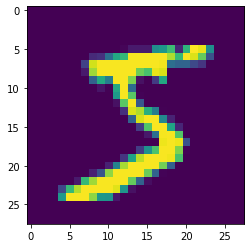

In [23]:
%matplotlib inline
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].reshape(28,28))

In [24]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


In [25]:
batch_size = 100

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [26]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

Our first model will be a regular MLP classifying MNIST digits without dropout. Recall that in this network, all neurons (or nodes) will be present for every training case.

In [27]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = 1) -> torch.tensor:
        if(exec_depth is 1):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_54887/3877752925.py:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(exec_depth is 1):


In [28]:
#TODO: Below, set the number of hidden units per layer and number of output classes
hidden_layers = [60,60,60] # this should be an array with units per hidden layer
num_classes = 10

vnn = VanillaNN(dataset[0][0].shape, hidden_layers, num_classes).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=60, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=60, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [29]:
# TODO: Set epochs and learning rate. Be sure the network's performance has begun to plateau for a good comparison
n_epochs = 15
lr = 1e-4

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [30]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

Epoch: 1/15, Iter: 100/480, Loss: 2.2826
Epoch: 1/15, Iter: 200/480, Loss: 2.0957
Epoch: 1/15, Iter: 300/480, Loss: 1.9138
Epoch: 1/15, Iter: 400/480, Loss: 1.8617
Epoch: 1/15, Iter: 480/480, Loss: 1.8428
Epoch 1 Train Accuracy: 65.88%
Epoch 1 Test Accuracy: 65.53%

Epoch: 2/15, Iter: 100/480, Loss: 1.8338
Epoch: 2/15, Iter: 200/480, Loss: 1.7378
Epoch: 2/15, Iter: 300/480, Loss: 1.6800
Epoch: 2/15, Iter: 400/480, Loss: 1.6690
Epoch: 2/15, Iter: 480/480, Loss: 1.6494
Epoch 2 Train Accuracy: 83.81%
Epoch 2 Test Accuracy: 82.90%

Epoch: 3/15, Iter: 100/480, Loss: 1.6814
Epoch: 3/15, Iter: 200/480, Loss: 1.6507
Epoch: 3/15, Iter: 300/480, Loss: 1.6530
Epoch: 3/15, Iter: 400/480, Loss: 1.5737
Epoch: 3/15, Iter: 480/480, Loss: 1.6205
Epoch 3 Train Accuracy: 87.00%
Epoch 3 Test Accuracy: 85.99%

Epoch: 4/15, Iter: 100/480, Loss: 1.6024
Epoch: 4/15, Iter: 200/480, Loss: 1.6166
Epoch: 4/15, Iter: 300/480, Loss: 1.5907
Epoch: 4/15, Iter: 400/480, Loss: 1.6165
Epoch: 4/15, Iter: 480/480, Loss: 1

In [31]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 92.02%


### Model With Dropout

Now, let's try the same network with dropout. Dropout is simple: For every layer, the input to any given neuron is zeroed out with probability *p*. When a neuron's input is zeroed out, it's effectively removed from the model. Which neurons are dropped are determined by a vector of 1's and 0's generated by a Bernoulli distribution (at least, in the paper) for each training case.

Notably, dropout effectively turns a single model into an ensemble of models that share weights, where each model in the ensemble is a random subnetwork that only rarely gets trained.

**TODO: How many subnetworks are possible in a network with *n* units?**

There are n! possible subnetworks, assuming that there is a possible connection between each unit.

**TODO: How does dropout change the relationship of units in the network with their neighbors?**

No unit can count on the existence of it's neighbors.

In [32]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            #TODO: Add dropout here (hint: there's a PyTorch function for it).
            #Which value from the dropout list should go here?
            nn.Dropout(p=dropout_values[0]),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                #TODO: Add dropout here too
                nn.Dropout(p=dv),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            #TODO: Last dropout call here. Which value should it take?
            nn.Dropout(p=dropout_values[-1]),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [33]:
# TODO: Specify number of hidden units per layer, per-layer dropout probability (between 0 and 1), and number of 
# output classes. How many per-layer dropout probabilities does this model require?
hidden_layers = [100,100,100]
dropout_probs = [0.2,0.5,0.5,0.5]
num_classes = 10

dnn = DropoutNN(dataset[0][0].shape, hidden_layers, dropout_probs, num_classes).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=100, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [34]:
# TODO: Set epochs and learning rate. Note that dropout substantially slows down training!
n_epochs2 = 35
lr2 = 1e-4

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

In [35]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

Epoch: 1/35, Iter: 100/480, Loss: 2.2980
Epoch: 1/35, Iter: 200/480, Loss: 2.2623
Epoch: 1/35, Iter: 300/480, Loss: 2.1637
Epoch: 1/35, Iter: 400/480, Loss: 2.0688
Epoch: 1/35, Iter: 480/480, Loss: 1.9345
Epoch 1 Train Accuracy: 58.89%
Epoch 1 Test Accuracy: 58.41%

Epoch: 2/35, Iter: 100/480, Loss: 1.9011
Epoch: 2/35, Iter: 200/480, Loss: 1.9131
Epoch: 2/35, Iter: 300/480, Loss: 1.9144
Epoch: 2/35, Iter: 400/480, Loss: 1.8266
Epoch: 2/35, Iter: 480/480, Loss: 1.8437
Epoch 2 Train Accuracy: 68.44%
Epoch 2 Test Accuracy: 68.09%

Epoch: 3/35, Iter: 100/480, Loss: 1.8280
Epoch: 3/35, Iter: 200/480, Loss: 1.7852
Epoch: 3/35, Iter: 300/480, Loss: 1.7613
Epoch: 3/35, Iter: 400/480, Loss: 1.8283
Epoch: 3/35, Iter: 480/480, Loss: 1.8503
Epoch 3 Train Accuracy: 77.23%
Epoch 3 Test Accuracy: 77.03%

Epoch: 4/35, Iter: 100/480, Loss: 1.8041
Epoch: 4/35, Iter: 200/480, Loss: 1.7888
Epoch: 4/35, Iter: 300/480, Loss: 1.7916
Epoch: 4/35, Iter: 400/480, Loss: 1.6876
Epoch: 4/35, Iter: 480/480, Loss: 1

Epoch: 31/35, Iter: 200/480, Loss: 1.5185
Epoch: 31/35, Iter: 300/480, Loss: 1.6173
Epoch: 31/35, Iter: 400/480, Loss: 1.5510
Epoch: 31/35, Iter: 480/480, Loss: 1.5776
Epoch 31 Train Accuracy: 94.01%
Epoch 31 Test Accuracy: 93.33%

Epoch: 32/35, Iter: 100/480, Loss: 1.5479
Epoch: 32/35, Iter: 200/480, Loss: 1.5075
Epoch: 32/35, Iter: 300/480, Loss: 1.5115
Epoch: 32/35, Iter: 400/480, Loss: 1.5835
Epoch: 32/35, Iter: 480/480, Loss: 1.5916
Epoch 32 Train Accuracy: 94.06%
Epoch 32 Test Accuracy: 93.27%

Epoch: 33/35, Iter: 100/480, Loss: 1.5150
Epoch: 33/35, Iter: 200/480, Loss: 1.5583
Epoch: 33/35, Iter: 300/480, Loss: 1.5199
Epoch: 33/35, Iter: 400/480, Loss: 1.5414
Epoch: 33/35, Iter: 480/480, Loss: 1.5126
Epoch 33 Train Accuracy: 94.22%
Epoch 33 Test Accuracy: 93.38%

Epoch: 34/35, Iter: 100/480, Loss: 1.5618
Epoch: 34/35, Iter: 200/480, Loss: 1.5557
Epoch: 34/35, Iter: 300/480, Loss: 1.5335
Epoch: 34/35, Iter: 400/480, Loss: 1.5600
Epoch: 34/35, Iter: 480/480, Loss: 1.5628
Epoch 34 T

In [36]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 93.55%


In the interest of time: if the dropout model performs slightly worse than or equivalent to the vanilla model, there should still be clear differences in the layers visualized below. If you have the time, experiment with the number of epochs, learning rate, and dropout probabillities to maximize the dropout model's performance, then compare against the vanilla model.

**TODO: How does the training rate of the dropout model compare to the vanilla model? Why does dropout have this effect on training rates?**

Dropout takes much longer than the vanilla model to train, since if a node is dropped out then and skipped by backpropagation it will take longer to train.  For example if each node has a 0.5 probability of getting dropped out, then it will take twice as long to train.  As well, if the node which learns a specific feature is suddenly dropped out the network must learn to recognize that feature without the specific node.

### Visualizing Model Layers

Now, let's visualize the first layer weights from both models:

In [37]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    fig.tight_layout()
    fig.show()

/tmp/ipykernel_54887/982768779.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


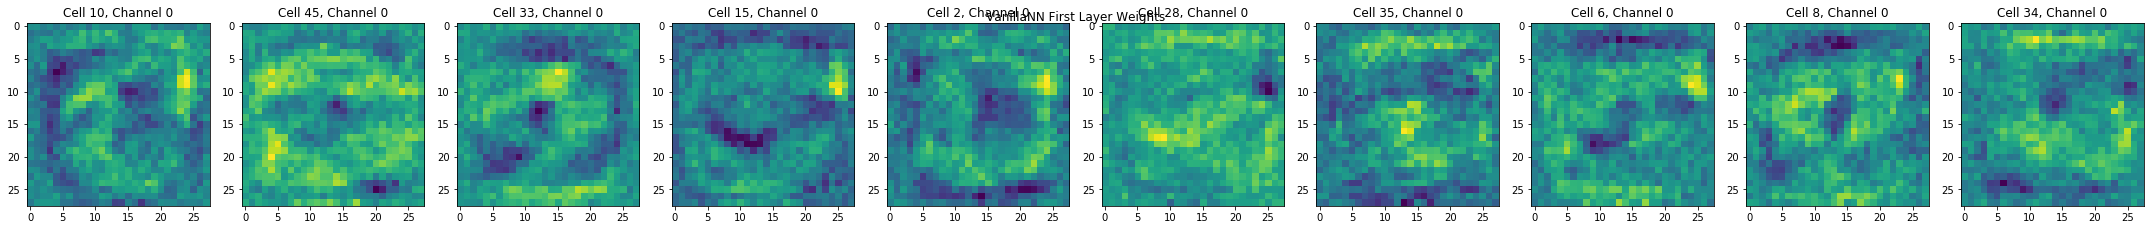

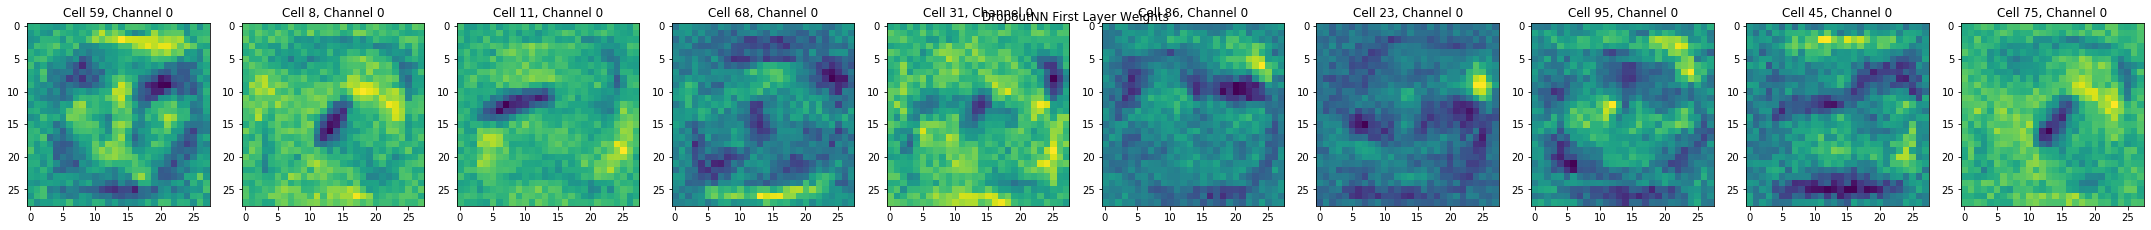

In [38]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)

Double click on each row of plots to make them larger!

**TODO: Are there visual differences between the vanilla and dropout model weights? How does dropout cause these differences in the weights?**

# Optimal Images 

Below, we choose random individual neurons from the 'vanilla' net and the dropout net. For each neuron, we train an optimal image to maximally activate its neuron, then display the optimal image.

In [39]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 4500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimize Values After Layer {model.linear_layer(run_through_layers - 1)}, Node: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

def random_optimal_images_from(
    model: nn.Module, 
    layer: int, 
    num_samples: int,
    width: int, 
    height: int, 
    depth: int, 
    device,
    *args,
    **kwargs
) -> tuple:
    imgs = []
    samples = np.random.choice(model.linear_layer(layer - 1).weight.shape[0], num_samples, replace=False)
    %matplotlib notebook
    
    for i, sample in enumerate(samples):
        print(f"Working on image {i + 1}/{num_samples}")
        imgs.append(
            generate_optimal_image(model, layer, sample, height, width, depth, device, *args, **kwargs)
        )
    
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(type(model).__name__)
    
    for img, sample_i, sub_axs in zip(imgs, samples, axs.T):
        for j, ax in enumerate(sub_axs):
            img2 = img.cpu().detach().numpy()[0, j]
            ax.set_title(f"Layer {layer}, Node {sample_i}, Channel {j}")
            m = ax.imshow(img2, cmap="plasma") 
    
    fig.colorbar(m)
    fig.tight_layout()
    fig.show()
    
    return fig, axs, imgs, samples

Working on image 1/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 0
Epoch: 0/4500, Loss: 0.70
Epoch: 500/4500, Loss: -5.71
Epoch: 1000/4500, Loss: -16.81
Epoch: 1500/4500, Loss: -23.55
Epoch: 2000/4500, Loss: -29.34
Epoch: 2500/4500, Loss: -34.24
Epoch: 3000/4500, Loss: -37.76
Epoch: 3500/4500, Loss: -39.45
Epoch: 4000/4500, Loss: -40.49
Epoch: 4499/4500, Loss: -41.07
Working on image 2/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 3
Epoch: 0/4500, Loss: 11.62
Epoch: 500/4500, Loss: -40.31
Epoch: 1000/4500, Loss: -56.79
Epoch: 1500/4500, Loss: -72.05
Epoch: 2000/4500, Loss: -84.69
Epoch: 2500/4500, Loss: -92.16
Epoch: 3000/4500, Loss: -95.63
Epoch: 3500/4500, Loss: -97.47
Epoch: 4000/4500, Loss: -98.55
Epoch: 4499/4500, Loss: -99.30
Working on image 3/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 8
Epoch: 0/4500, Loss: 13.07
Epoch: 500/4500, Loss: -14.81
Epoch

<IPython.core.display.Javascript object>


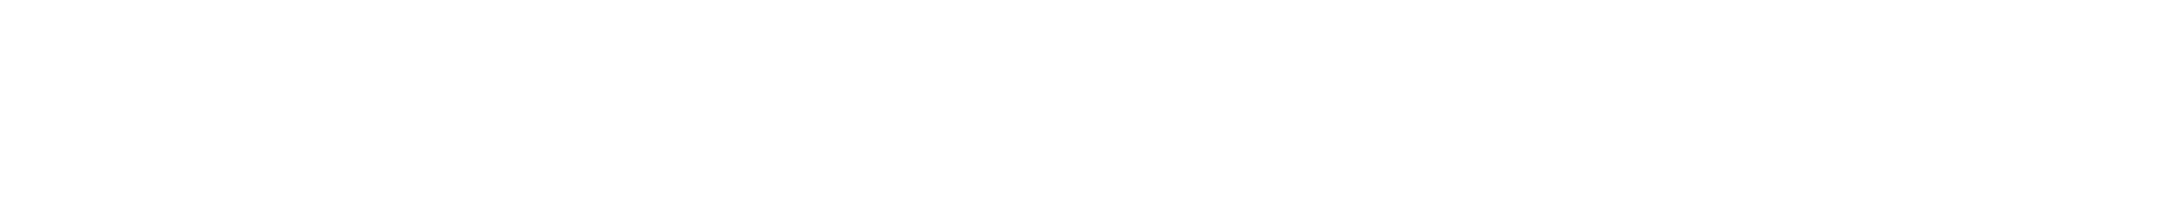

Working on image 1/10
Optimize Values After Layer Linear(in_features=100, out_features=10, bias=True), Node: 4
Epoch: 0/4500, Loss: 21.84
Epoch: 500/4500, Loss: 1.66
Epoch: 1000/4500, Loss: -0.73
Epoch: 1500/4500, Loss: -3.08
Epoch: 2000/4500, Loss: -30.78
Epoch: 2500/4500, Loss: -67.52
Epoch: 3000/4500, Loss: -81.02
Epoch: 3500/4500, Loss: -84.47
Epoch: 4000/4500, Loss: -85.92
Epoch: 4499/4500, Loss: -86.61
Working on image 2/10
Optimize Values After Layer Linear(in_features=100, out_features=10, bias=True), Node: 6
Epoch: 0/4500, Loss: 78.37
Epoch: 500/4500, Loss: -0.04
Epoch: 1000/4500, Loss: -22.64
Epoch: 1500/4500, Loss: -66.93
Epoch: 2000/4500, Loss: -96.95
Epoch: 2500/4500, Loss: -107.02
Epoch: 3000/4500, Loss: -110.17
Epoch: 3500/4500, Loss: -110.90
Epoch: 4000/4500, Loss: -111.28
Epoch: 4499/4500, Loss: -111.52
Working on image 3/10
Optimize Values After Layer Linear(in_features=100, out_features=10, bias=True), Node: 1
Epoch: 0/4500, Loss: 68.09
Epoch: 500/4500, Loss: 1.61
Ep

<IPython.core.display.Javascript object>


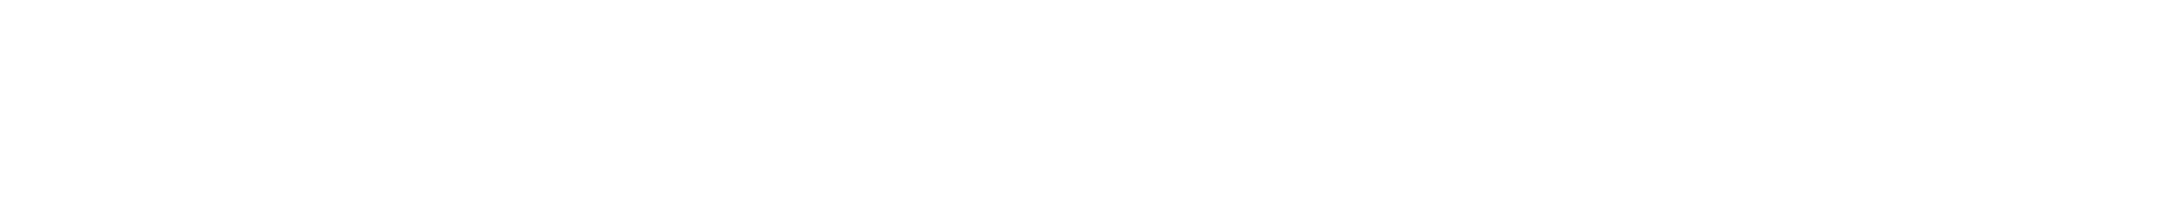

In [62]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 4, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 4, 10, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


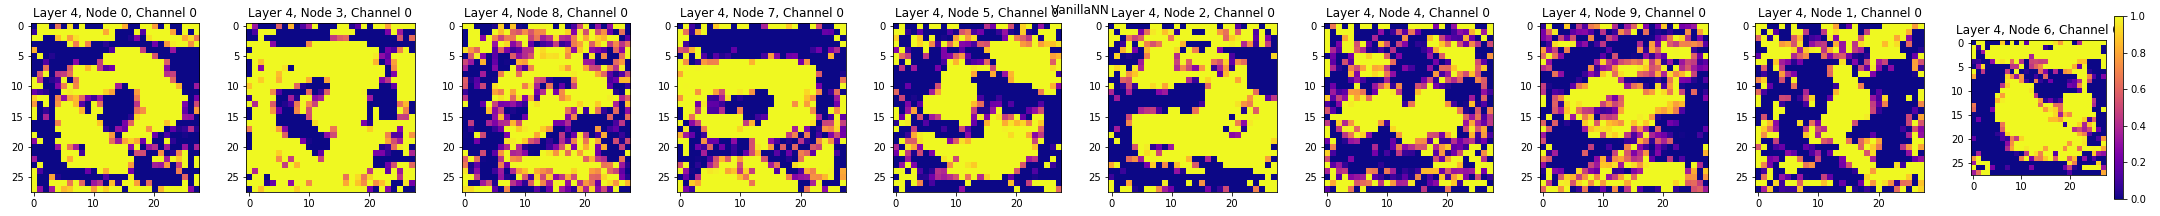

In [63]:
vanilla_res

<IPython.core.display.Javascript object>


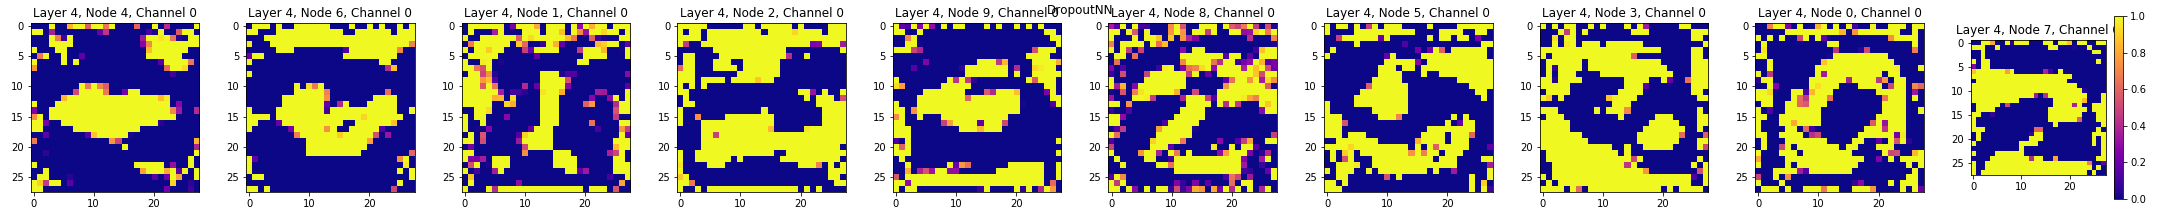

In [64]:
dropout_res

**TODO: Are there any differences between the 'vanilla' net optimal images and the dropout net optimal images? If so, what do you think led to these differences?**

Yes, generally the dropout net images have less noise than the vanilla net images.  This means that for the randomly selected neurons there is a specific set of pixels that either activate or don't activate the neuron whereas for the vanilla net images the neurons are optimally activated by partially filled pixels.  This is likely because the neurons in the dropout net can't rely on any specific pixel being partially activated by another neuron and thus must communicate information about that pixel on their own.

Working on image 1/10
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 50
Epoch: 0/4500, Loss: 5.41
Epoch: 500/4500, Loss: 3.45
Epoch: 1000/4500, Loss: 0.20
Epoch: 1500/4500, Loss: -1.77
Epoch: 2000/4500, Loss: -2.35
Epoch: 2500/4500, Loss: -2.87
Epoch: 3000/4500, Loss: -3.33
Epoch: 3500/4500, Loss: -3.74
Epoch: 4000/4500, Loss: -4.06
Epoch: 4499/4500, Loss: -4.33
Working on image 2/10
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 43
Epoch: 0/4500, Loss: 1.56
Epoch: 500/4500, Loss: 4.70
Epoch: 1000/4500, Loss: 3.44
Epoch: 1500/4500, Loss: 2.69
Epoch: 2000/4500, Loss: 2.18
Epoch: 2500/4500, Loss: 1.80
Epoch: 3000/4500, Loss: 1.50
Epoch: 3500/4500, Loss: 1.27
Epoch: 4000/4500, Loss: 1.09
Epoch: 4499/4500, Loss: 0.94
Working on image 3/10
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 8
Epoch: 0/4500, Loss: 2.54
Epoch: 500/4500, Loss: -0.10
Epoch: 1000/4500, Loss: -3.77
Epoc

<IPython.core.display.Javascript object>


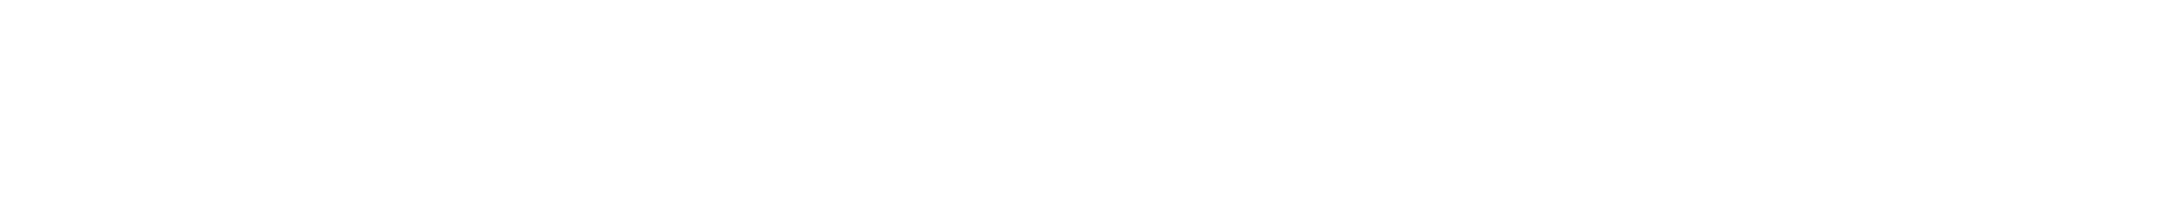

Working on image 1/10
Optimize Values After Layer Linear(in_features=100, out_features=100, bias=True), Node: 42
Epoch: 0/4500, Loss: 9.00
Epoch: 500/4500, Loss: 0.39
Epoch: 1000/4500, Loss: 0.14
Epoch: 1500/4500, Loss: 0.10
Epoch: 2000/4500, Loss: 0.09
Epoch: 2500/4500, Loss: 0.07
Epoch: 3000/4500, Loss: 0.07
Epoch: 3500/4500, Loss: 0.06
Epoch: 4000/4500, Loss: 0.05
Epoch: 4499/4500, Loss: -0.01
Working on image 2/10
Optimize Values After Layer Linear(in_features=100, out_features=100, bias=True), Node: 68
Epoch: 0/4500, Loss: 7.47
Epoch: 500/4500, Loss: 0.54
Epoch: 1000/4500, Loss: 0.42
Epoch: 1500/4500, Loss: 0.40
Epoch: 2000/4500, Loss: 0.40
Epoch: 2500/4500, Loss: 0.39
Epoch: 3000/4500, Loss: 0.39
Epoch: 3500/4500, Loss: 0.39
Epoch: 4000/4500, Loss: 0.38
Epoch: 4499/4500, Loss: 0.38
Working on image 3/10
Optimize Values After Layer Linear(in_features=100, out_features=100, bias=True), Node: 57
Epoch: 0/4500, Loss: 16.69
Epoch: 500/4500, Loss: 0.14
Epoch: 1000/4500, Loss: -0.00
Epo

<IPython.core.display.Javascript object>


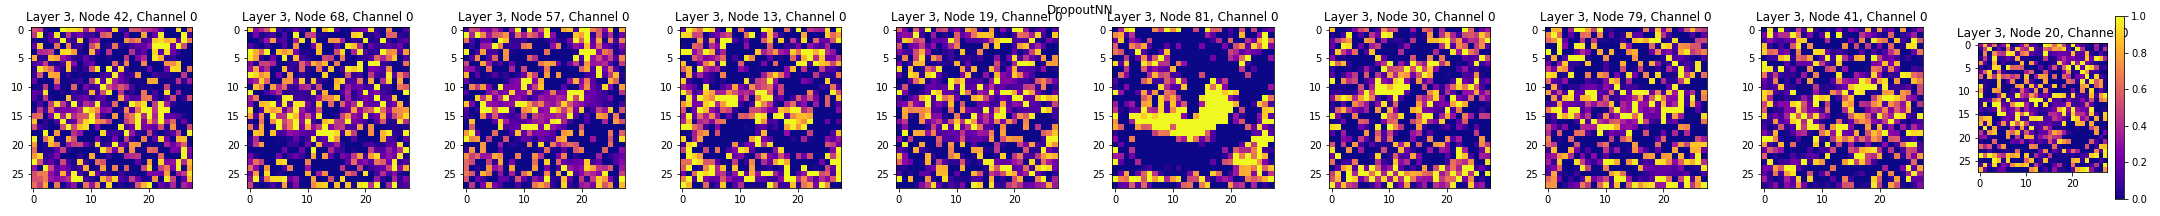

In [65]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 3, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 3, 10, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


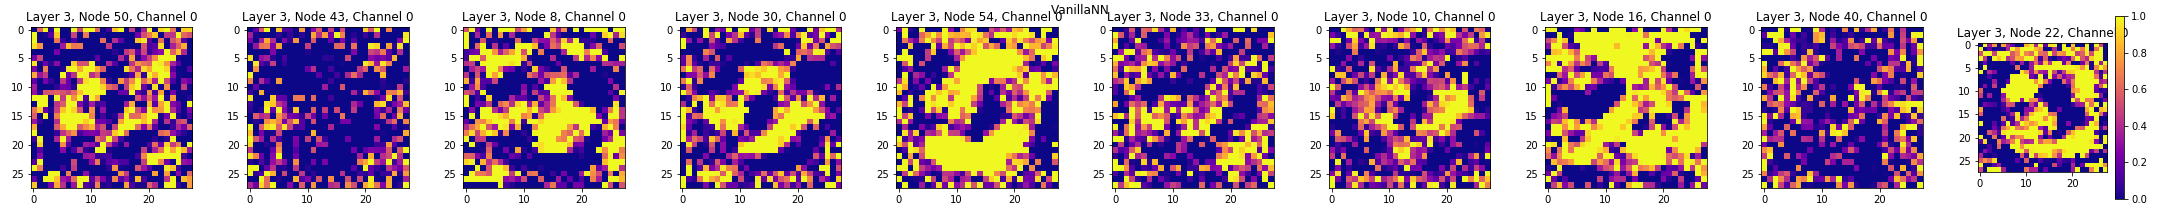

In [66]:
vanilla_res

<IPython.core.display.Javascript object>


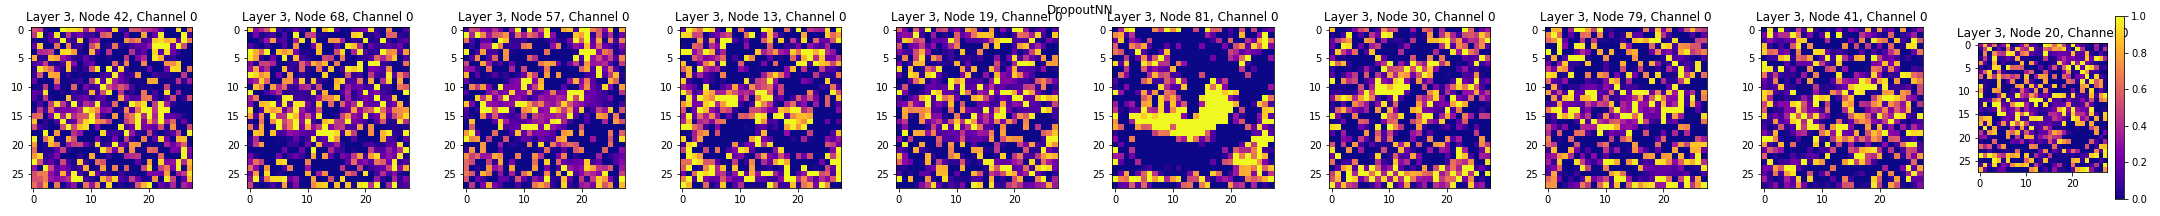

In [67]:
dropout_res

Working on image 1/10
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 55
Epoch: 0/4500, Loss: 2.95
Epoch: 500/4500, Loss: 1.07
Epoch: 1000/4500, Loss: -1.03
Epoch: 1500/4500, Loss: -1.93
Epoch: 2000/4500, Loss: -2.50
Epoch: 2500/4500, Loss: -2.96
Epoch: 3000/4500, Loss: -3.41
Epoch: 3500/4500, Loss: -3.78
Epoch: 4000/4500, Loss: -4.09
Epoch: 4499/4500, Loss: -4.33
Working on image 2/10
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 27
Epoch: 0/4500, Loss: 5.32
Epoch: 500/4500, Loss: 4.65
Epoch: 1000/4500, Loss: 1.31
Epoch: 1500/4500, Loss: -0.07
Epoch: 2000/4500, Loss: -0.63
Epoch: 2500/4500, Loss: -0.96
Epoch: 3000/4500, Loss: -1.19
Epoch: 3500/4500, Loss: -1.40
Epoch: 4000/4500, Loss: -1.57
Epoch: 4499/4500, Loss: -1.72
Working on image 3/10
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 3
Epoch: 0/4500, Loss: 4.43
Epoch: 500/4500, Loss: 7.41
Epoch: 1000/4500, Loss: 4.8

<IPython.core.display.Javascript object>


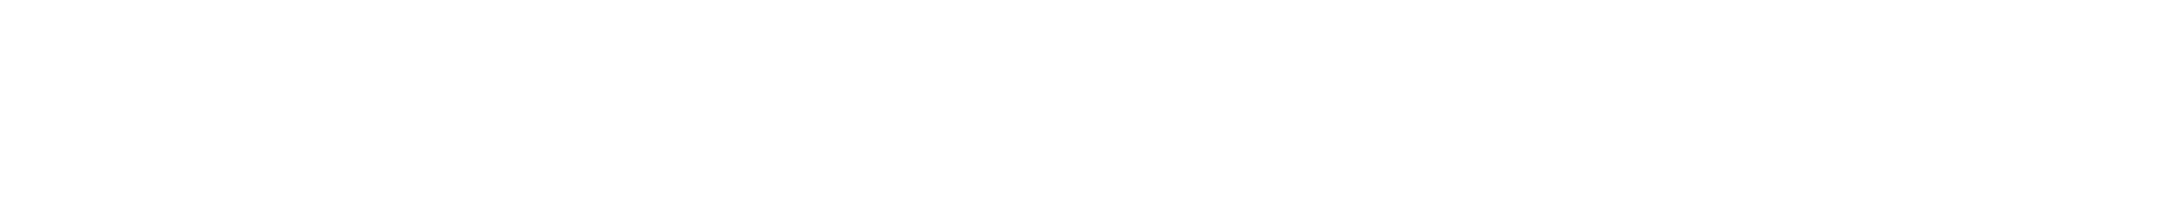

Working on image 1/10
Optimize Values After Layer Linear(in_features=100, out_features=100, bias=True), Node: 55
Epoch: 0/4500, Loss: 1.64
Epoch: 500/4500, Loss: -0.35
Epoch: 1000/4500, Loss: -1.08
Epoch: 1500/4500, Loss: -2.11
Epoch: 2000/4500, Loss: -2.77
Epoch: 2500/4500, Loss: -3.24
Epoch: 3000/4500, Loss: -3.52
Epoch: 3500/4500, Loss: -3.69
Epoch: 4000/4500, Loss: -3.82
Epoch: 4499/4500, Loss: -3.92
Working on image 2/10
Optimize Values After Layer Linear(in_features=100, out_features=100, bias=True), Node: 69
Epoch: 0/4500, Loss: 6.39
Epoch: 500/4500, Loss: 0.04
Epoch: 1000/4500, Loss: -0.04
Epoch: 1500/4500, Loss: -0.06
Epoch: 2000/4500, Loss: -0.08
Epoch: 2500/4500, Loss: -0.09
Epoch: 3000/4500, Loss: -0.11
Epoch: 3500/4500, Loss: -0.13
Epoch: 4000/4500, Loss: -0.14
Epoch: 4499/4500, Loss: -0.16
Working on image 3/10
Optimize Values After Layer Linear(in_features=100, out_features=100, bias=True), Node: 14
Epoch: 0/4500, Loss: 9.00
Epoch: 500/4500, Loss: 0.50
Epoch: 1000/4500, 

<IPython.core.display.Javascript object>


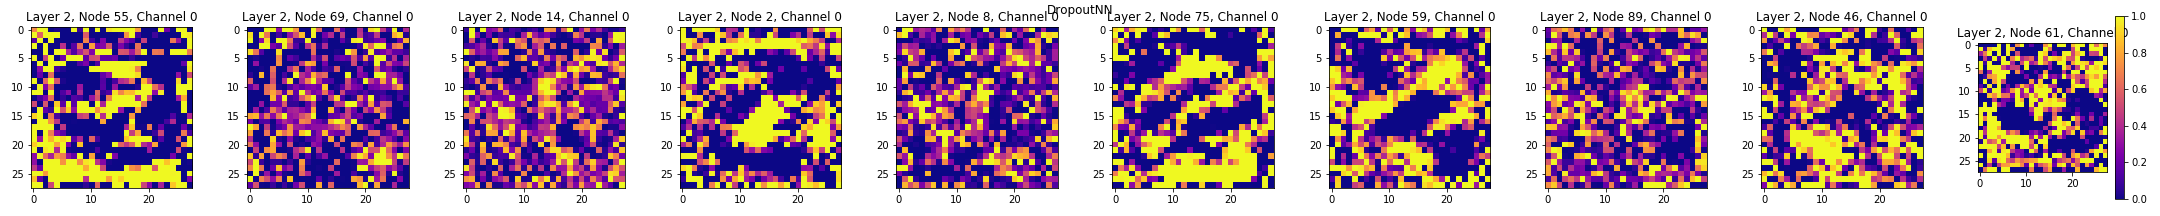

In [68]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 2, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 2, 10, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


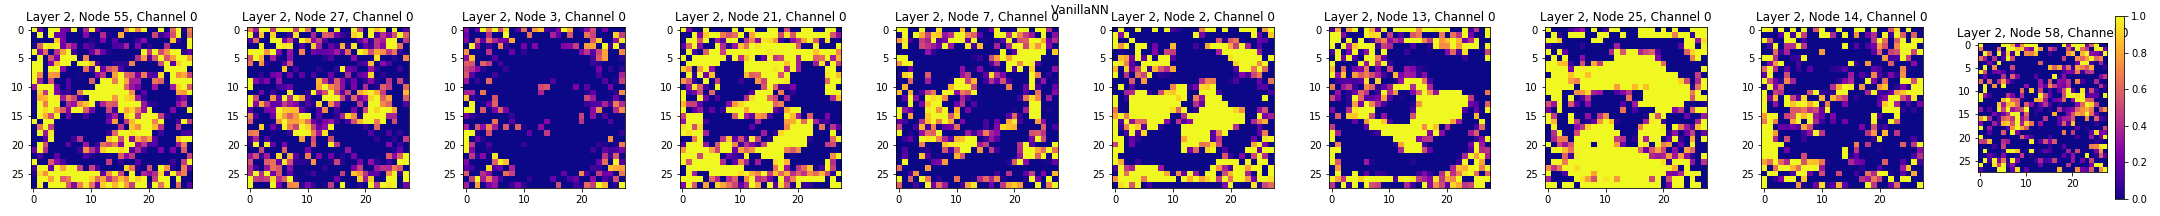

In [69]:
vanilla_res

<IPython.core.display.Javascript object>


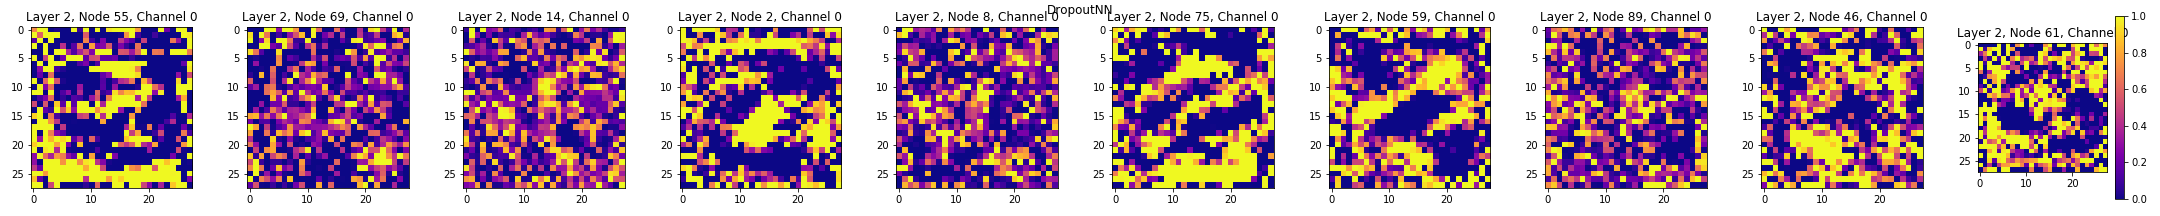

In [70]:
dropout_res

**TODO: The above function allows you to randomly sample nodes from any layer of the network for generating optimal images (Currently set to layer 4, the final layer output). What results do you get when changing the layer optimal images are being generated for? How do the Vanilla NN and Dropout NN results compare and differ?**

Generally the earlier nodes are more likely to be noisier for both the vanilla and dropout nets.  However, there are several nodes for the dropout nets which appear to have a significant amount of random noise compared to the nodes from the vanilla net.  This is likely because those nodes are contributing little useful information to the output.  In other words, due to their absence the network has learned to generate a valid output without a significant contribution from those nodes.